In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import urllib
from PIL import Image
from bs4 import BeautifulSoup
import requests
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import pickle
movie_df = pd.read_csv("shuffled_movie_df.csv")
pickle.dump(movie_df, open("shuffled_movie_df.pkl", "wb"))
pickle_movie = pickle.load(open("shuffled_movie_df.pkl", "rb"))
movie_df.head()
pickle_movie.head()

,Movie Name,Poster Image Link,Synopsis,Genre,IMDb_id,Plot Keywords,Storyline,Genre Variations
0,Big Fish,https://m.media-amazon.com/images/M/MV5BMTYyMz...,A frustrated son tries to determine the fa...,Adventure,tt0319061,fish father son relationship death of father f...,United Press International journalist Will...,Adventure Drama Fantasy
1,Scott Pilgrim vs. the World,https://m.media-amazon.com/images/M/MV5BMTkwNT...,Scott Pilgrim must defeat his new girlfrie...,Action,tt0446029,toronto canada sexy woman cleavage panties sca...,Scott Pilgrim plays in a band which aspire...,Action Comedy Fantasy
2,The Paleface,https://m.media-amazon.com/images/M/MV5BOGZhMG...,Calamity Jane is despatched to find out wh...,Western,tt0040679,comedy of errors misunderstanding punched in t...,Someone is selling guns to the Indians and...,Comedy Family Western
3,How the West Was Won,https://m.media-amazon.com/images/M/MV5BNTk2ND...,A family saga covering several decades of ...,Western,tt0056085,ulysses s. grant character abraham lincoln cha...,Setting off on a journey to the west in th...,Western
4,The Butterfly Effect,https://m.media-amazon.com/images/M/MV5BODNiZm...,Evan Treborn suffers blackouts during sign...,Sci-Fi,tt0289879,love butterfly effect child pornography time t...,Evan Treborn grows up in a small town with...,Drama Sci-Fi Thriller


In [2]:
movie_df["Plot Keywords"].fillna("",inplace=True)

# Introduction to the File:
In this file, we ensemble the models we built in ML_1, ML_2, and ML_3 with the best k value we found. We build multiple ensembles and find the best ensemble model.
Model 1, Model 2, Model 3, and Model 4 are the models we got from ML_1, ML_2, and ML_3 that we use to build out Ensemble Models in this file.

#### NOTE:  <br>"Genre Variations" is a column containing all the genres of the movie since the movie can have multiple genres. <br> "Genre" is the most prominent genre of the movie i.e. for example, a movie can be more sci-fi than it is horror such as the movie "Alien"). Hence, we made our own function for finding accuracy and F1 scores.<br> For us, the machine learning model predicts "correctly" if the genre it predicts matches one of the genres from the "Genre Variations" column in the data frame. Hence, we made our own Accuracy function and F1 Score function to reflect this.


####  NOTE: this model we explore here is different from the model we create in ML_1 in that we use another cv value in cross validation on our model using tfidf on text from Synopsis to find another good k value. in ML_4, we combine both models models using tfidf on text from Synopsis with two different optimal k values we found.

#### NOTE: in this file, we deal with test/validation accuracy and test/validation f1 score, not training metrics for classifiers.

## Model 1 - Tfidf on text of Synopsis as features with k = 19
In ML_1, we found that using Tfidf on text of Synopsis as features with k = 19 returns good f1 scores and accuracy for most genres. K = 19 may not be the best k value for every genre, but it consistanntly gets f1 scores close to the highest f1 scores for most genres and also gets a good accuracy score.

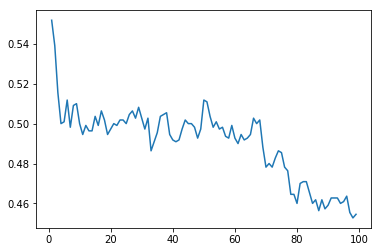

In [3]:
def getAccuracy(k):
    vec = TfidfVectorizer()
    vec.fit(movie_df["Synopsis"])
    X_train = vec.transform(movie_df["Synopsis"])
    y_train =  movie_df["Genre"]
    y_all_genres = movie_df["Genre Variations"]
    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    accuracy = 0
    accuracy1 = 0
    for i in range(0, len(predicted), 1):
        if predicted[i] in  y_genres_list[i]:
            accuracy += 1
    return accuracy/len(y_all_genres)
  
ks = pd.Series(range(1, 100,1))
ks.index = range(1, 100,1)
test_errs = ks.apply(getAccuracy)

test_errs.plot.line()

Horror
0.4530386740331491
11    0.415929
8     0.420561
13    0.424242
12    0.425000
3     0.426230
17    0.426778
10    0.427948
18    0.429752
2     0.447489
4     0.453039
dtype: float64

Western
0.5617977528089888
13    0.477273
10    0.485207
12    0.485549
11    0.497110
14    0.502857
15    0.508671
16    0.519774
18    0.539326
17    0.550562
19    0.561798
dtype: float64

War
0.42857142857142855
6     0.389937
12    0.390244
19    0.395480
13    0.397590
16    0.400000
15    0.407186
18    0.416667
9     0.423077
14    0.423529
17    0.428571
dtype: float64

Sci-Fi
0.4592592592592593
13    0.419476
10    0.419476
11    0.422222
6     0.426357
15    0.437037
16    0.437037
19    0.437037
12    0.437736
18    0.456929
17    0.459259
dtype: float64

Action
0.4753747323340472
10    0.348235
12    0.365796
7     0.373576
8     0.377622
9     0.381176
6     0.417204
4     0.445759
5     0.452675
3     0.473896
2     0.475375
dtype: float64

Adventure
0.4473684210526316
7     0.3282

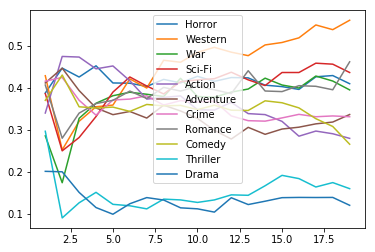

In [4]:
def getF1(k,genre):
    vec = TfidfVectorizer()
    vec.fit(movie_df["Synopsis"])
    X_train = vec.transform(movie_df["Synopsis"])
    y_train =  movie_df["Genre"]
    y_all_genres = movie_df["Genre Variations"]
    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")

    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(pipeline, X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = genre
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
genres=["Horror","Western","War","Sci-Fi","Action","Adventure",
       "Crime","Romance","Comedy","Thriller","Drama"]
def getBestKVals():
    for genre in genres:
        ks = pd.Series(range(1, 20,1))
        ks.index = range(1, 20,1)
        test_errs = ks.apply(getF1,args=(genre,))
        print(genre)
        print(test_errs.max())
        print(test_errs.sort_values()[-10:])
        test_errs.plot.line(legend=True,label=genre)
        print()

getBestKVals()

#### K = 19

In [5]:
for genre in genres:
    print(genre)
    print(getF1(19,genre))
print("acc: ",getAccuracy(19))

Horror
0.4102564102564102
Western
0.5617977528089888
War
0.3954802259887006
Sci-Fi
0.437037037037037
Action
0.27979274611398963
Adventure
0.336734693877551
Crime
0.33146067415730335
Romance
0.4625850340136055
Comedy
0.26578073089701
Thriller
0.1597222222222222
Drama
0.12
acc:  0.49454545454545457


## Model 2 - Tfidf on text of Synopsis as features with k = 2
In ML_3, we found that using Tfidf on text of Synopsis as features with k = 2 also returns good f1 scores and accuracy for most genres. For the genres K = 19 performed bad on, the model with k = 2 works better. K = 2 may not be the best k value for every genre, but it consistanntly gets f1 scores close to the highest f1 scores for most genres and also gets a good accuracy score.

In [6]:
from collections import Counter
movies_df = movie_df
bag_of_words = (
    movies_df["Synopsis"].
    str.lower().
    str.replace("[^A-Za-z\s]", "").
    str.split()
).apply(Counter)

tf = pd.DataFrame(list(bag_of_words)).fillna(0)
df = (tf > 0).sum(axis=0)
idf = np.log(len(tf) / df)
tf_idf = tf * idf
#tf_idf = tf_idf[words]
tf_idf

words = tf_idf.columns
tf_idf["Genre"] = movies_df["Genre"]
tf_idf["Genre Variations"] = movies_df["Genre Variations"]
tf_idf.head()


,a,abagnale,abandoned,abandons,abducted,abductees,abducts,aberration,abilities,ability,...,zion,zodiac,zombie,zombiefilled,zombies,zone,zorg,zubrowka,Genre,Genre Variations
0,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Adventure,Adventure Drama Fantasy
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Action,Action Comedy Fantasy
2,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western,Comedy Family Western
3,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western,Western
4,0.383642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sci-Fi,Drama Sci-Fi Thriller


21    0.525455
19    0.526364
20    0.533636
1     0.534545
2     0.535455
dtype: float64

1     0.534545
2     0.535455
3     0.492727
4     0.498182
5     0.490000
6     0.483636
7     0.492727
8     0.491818
9     0.498182
10    0.495455
dtype: float64

34    0.507273
35    0.498182
36    0.497273
37    0.512727
38    0.509091
39    0.504545
40    0.506364
41    0.505455
42    0.506364
43    0.503636
44    0.506364
45    0.507273
dtype: float64



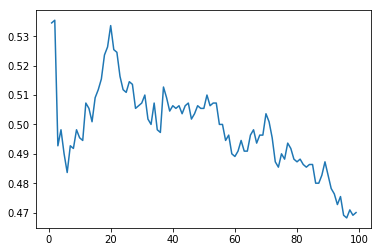

In [7]:
def getAccuracy(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    accuracy = 0
    accuracy1 = 0
    for i in range(0, len(predicted), 1):
        if predicted[i] in  y_genres_list[i]:
            accuracy += 1
    return accuracy/len(y_all_genres)
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getAccuracy)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()  


Horror
0.47058823529411764
16    0.451613
19    0.455814
15    0.457944
30    0.460870
4     0.463158
21    0.464912
18    0.465753
20    0.466368
14    0.466368
17    0.470588
dtype: float64

Western
0.6021505376344085
37    0.583784
21    0.585106
41    0.585106
18    0.585106
24    0.588235
25    0.589474
45    0.589474
23    0.593750
27    0.597826
26    0.602151
dtype: float64

War
0.4680851063829787
39    0.445652
12    0.445860
37    0.448087
50    0.448087
48    0.452632
49    0.454054
44    0.455026
46    0.457447
47    0.465608
45    0.468085
dtype: float64

Sci-Fi
0.47311827956989244
32    0.450512
50    0.453608
37    0.459364
42    0.460432
49    0.461017
38    0.463158
48    0.464164
47    0.467354
46    0.470175
45    0.473118
dtype: float64

Action
0.47418738049713194
14    0.389671
20    0.392252
13    0.393519
9     0.402655
12    0.406467
10    0.412417
4     0.445312
5     0.448000
2     0.467091
3     0.474187
dtype: float64

Adventure
0.4814004376367615
45    0.29

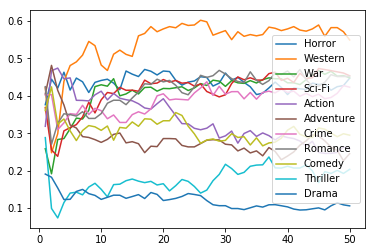

In [8]:
def getF1(k,genre):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = genre
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))

genres=["Horror","Western","War","Sci-Fi","Action","Adventure",
       "Crime","Romance","Comedy","Thriller","Drama"]
def getBestKVals():
    for genre in genres:
        ks = pd.Series(range(1, 51,1))
        ks.index = range(1, 51,1)
        test_errs = ks.apply(getF1,args=(genre,))
        print(genre)
        print(test_errs.max())
        print(test_errs.sort_values()[-10:])
        test_errs.plot.line(legend=True,label=genre)
        print()

getBestKVals()

#### K = 2

In [9]:
for genre in genres:
    print(genre)
    print(getF1(2,genre))
print("acc: ",getAccuracy(2))

Horror
0.4444444444444445
Western
0.24778761061946902
War
0.19148936170212766
Sci-Fi
0.2555066079295154
Action
0.4670912951167728
Adventure
0.4814004376367615
Crime
0.4030226700251889
Romance
0.27049180327868855
Comedy
0.42391304347826086
Thriller
0.0988593155893536
Drama
0.182312925170068
acc:  0.5354545454545454


## Ensembler Model 1 - 
### Ensembler of two models : Model 1 and Model 2
### Ensemble method : Ensembler by picking class with best probability accross the 2 models

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class ClassifierEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if( i == 0):
                estimator.fit(X1, y)
            else:
                estimator.fit(X2, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            else:
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            currclasses.append(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        
        for i in range(0,len(Y_), 1):
            x1_maxprob = max(X1_probs[i])
            x2_maxprob = max(X2_probs[i])
            if(x1_maxprob > x2_maxprob):
                result.append(Y_[i][0])
            else:
                 result.append(Y_[i][1])
        return result

In [11]:
X_train1 = tf_idf[words]
y_train = tf_idf["Genre"]

vec = TfidfVectorizer()
vec.fit(movie_df["Synopsis"])
tf_idf_sparse = vec.transform(movie_df["Synopsis"])

x1Features = words
x2Features = vec.get_feature_names()

X_train2 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec.get_feature_names())

X_train = pd.concat([X_train1, X_train2], axis=1)

model1 = KNeighborsClassifier(n_neighbors = 19, metric = "cosine")

model2 = KNeighborsClassifier(n_neighbors = 2, metric = "cosine")

ensemble_1 = ClassifierEnsembler([model1, model2], False)

ensemble_1.fit(X_train, y_train)

ensemble_1.predict(X_train)

['Action',
 'Action',
 'Western',
 'Western',
 'Sci-Fi',
 'Comedy',
 'Action',
 'Romance',
 'War',
 'Crime',
 'Crime',
 'Horror',
 'Adventure',
 'Adventure',
 'Thriller',
 'Romance',
 'Crime',
 'Thriller',
 'Comedy',
 'Adventure',
 'Comedy',
 'Drama',
 'Crime',
 'War',
 'Crime',
 'Adventure',
 'Adventure',
 'Drama',
 'Drama',
 'Crime',
 'Comedy',
 'Adventure',
 'Romance',
 'Adventure',
 'Adventure',
 'Action',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Adventure',
 'Romance',
 'Action',
 'Comedy',
 'Comedy',
 'Thriller',
 'Crime',
 'Sci-Fi',
 'Adventure',
 'Comedy',
 'Romance',
 'Drama',
 'Action',
 'Romance',
 'Horror',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Crime',
 'War',
 'Drama',
 'Horror',
 'Adventure',
 'Crime',
 'Action',
 'Action',
 'Action',
 'Crime',
 'Action',
 'Drama',
 'Drama',
 'Thriller',
 'Adventure',
 'Thriller',
 'Drama',
 'Comedy',
 'Horror',
 'Comedy',
 'Comedy',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Crime',
 'Western',
 'Crime',
 'Comedy',
 'Crime',
 'Western'

In [12]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler([model1, model2], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1  



Horror f1 Score =   0.4857142857142857
Western f1 Score =   0.2833333333333334
War f1 Score =   0.23423423423423423
Sci-Fi f1 Score =   0.26666666666666666
Action f1 Score =   0.48861283643892345
Adventure f1 Score =   0.4545454545454546
Crime f1 Score =   0.4039900249376559
Romance f1 Score =   0.2892561983471074
Comedy f1 Score =   0.41159420289855075
Thriller f1 Score =   0.10196078431372549
Drama f1 Score =   0.1989247311827957


In [13]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler([model1, model2], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
accuracy1 = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.5481818181818182

The f1 score from this ensembler yeilds better results for most genres. For some genres, the previous models had better f1 scores, but only better by a little bit. However, the f1 scores for the ensembler are a lot higher for some genres like Horror, Western, or War. The accuracy for this enesembler model was also a little bit higher. Hence, overall, the ensembler created here yeilds better results.

## Model 3 - Tfidf on text in Key Words with k = 6
In ML_1, we found that using Tfidf on text in Key Words as features with k = 6 also returns good f1 scores and accuracy for most genres. We will use this model to build another ensembler, Ensembler Model 2.1, 2.2, and 2.3

In [14]:
vec3 = TfidfVectorizer()
vec3.fit(movie_df["Plot Keywords"])
tf_idf_sparse = vec3.transform(movie_df["Plot Keywords"])
X_train_3 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec3.get_feature_names())
y_train = tf_idf["Genre"]
model3 = KNeighborsClassifier(n_neighbors = 6, metric = "cosine")

## Ensembler Model 2.1 - 
### Ensembler of three models : Model 1 and Model 2 and Model 3
### Ensemble method : Ensemble by picking class with best probability accross the 3 models

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class ClassifierEnsembler3Way(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            else:
                estimator.fit(X3, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            else:
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            currclasses.append(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            x1_maxprob = max(X1_probs[i])
            x2_maxprob = max(X2_probs[i])
            x3_maxprob = max(X3_probs[i])
            if(max(x1_maxprob, x2_maxprob, x3_maxprob) == x1_maxprob):
                result.append(Y_[i][0])
            elif(max(x1_maxprob, x2_maxprob, x3_maxprob) == x2_maxprob):
                 result.append(Y_[i][1])
            else:
                result.append(Y_[i][2]) 
        return result

In [16]:
X_train1 = tf_idf[words]
y_train = tf_idf["Genre"]

vec2 = TfidfVectorizer()
vec2.fit(movie_df["Synopsis"])
tf_idf_sparse = vec2.transform(movie_df["Synopsis"])
X_train2 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec2.get_feature_names())

vec3 = TfidfVectorizer()
vec3.fit(movie_df["Plot Keywords"])
tf_idf_sparse = vec3.transform(movie_df["Plot Keywords"])
X_train_3 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec3.get_feature_names())

x1Features = words
x2Features = vec2.get_feature_names()
x3Features = vec3.get_feature_names()

X_train = pd.concat([X_train1, X_train2, X_train_3], axis=1)

model1 = KNeighborsClassifier(n_neighbors = 19, metric = "cosine")

model2 = KNeighborsClassifier(n_neighbors = 2, metric = "cosine")

model3 = KNeighborsClassifier(n_neighbors = 6, metric = "cosine")

ensemble_2_1 = ClassifierEnsembler3Way([model1, model2, model3], False)

ensemble_2_1.fit(X_train, y_train)

ensemble_2_1.predict(X_train)

['Action',
 'Action',
 'Western',
 'Western',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Romance',
 'War',
 'Crime',
 'Crime',
 'Horror',
 'Adventure',
 'Adventure',
 'Thriller',
 'Romance',
 'Crime',
 'Thriller',
 'Comedy',
 'Adventure',
 'Comedy',
 'Drama',
 'Crime',
 'War',
 'Crime',
 'Adventure',
 'Adventure',
 'Drama',
 'Drama',
 'Crime',
 'Comedy',
 'Adventure',
 'Romance',
 'Adventure',
 'Adventure',
 'Action',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Adventure',
 'Romance',
 'Action',
 'Comedy',
 'Comedy',
 'Thriller',
 'Crime',
 'Sci-Fi',
 'Adventure',
 'Comedy',
 'Romance',
 'Drama',
 'Action',
 'Romance',
 'Sci-Fi',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Crime',
 'War',
 'Drama',
 'Horror',
 'Adventure',
 'Crime',
 'Action',
 'Action',
 'Action',
 'Crime',
 'Action',
 'Drama',
 'Drama',
 'Thriller',
 'Adventure',
 'Thriller',
 'Drama',
 'Comedy',
 'Horror',
 'Comedy',
 'Comedy',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Crime',
 'Western',
 'Crime',
 'Comedy',
 'Crime',
 'Weste

In [17]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler3Way([model1, model2, model3], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1

#Horror f1 Score =   0.4811320754716981
#Western f1 Score =   0.41791044776119407
#War f1 Score =   0.2758620689655172
#Sci-Fi f1 Score =   0.29824561403508776
#Action f1 Score =   0.48218029350104824
#Adventure f1 Score =   0.4576659038901602
#Crime f1 Score =   0.4070351758793969
#Romance f1 Score =   0.30452674897119336
#Comedy f1 Score =   0.39762611275964393
#Thriller f1 Score =   0.08695652173913045
#Drama f1 Score =   0.20242914979757085

Horror f1 Score =   0.4811320754716981
Western f1 Score =   0.41791044776119407
War f1 Score =   0.2758620689655172
Sci-Fi f1 Score =   0.29824561403508776
Action f1 Score =   0.48218029350104824
Adventure f1 Score =   0.4576659038901602
Crime f1 Score =   0.4070351758793969
Romance f1 Score =   0.30452674897119336
Comedy f1 Score =   0.39762611275964393
Thriller f1 Score =   0.08695652173913045
Drama f1 Score =   0.20242914979757085


In [24]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler3Way([model1, model2, model3], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
accuracy1 = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.5590909090909091

Ensembler 2.1 worked a lot better than the previous models (model 1, model 2, and model 3) and even Ensembler 1. We can see a huge improvement in the Western f1 score. There are also improvements in f1 score for numerous other categories. Lastly, the accuracy for 2.1 was also a lot higher than the individual models or even the previous ensembler.

## Ensembler Model 2.2 - 
### Ensembler of three models : Model 1 and Model 2 and Model 3
### Ensemble method : Ensemble by picking class with highest vote among the predictions of the 3 models

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from collections import Counter 
import operator
class ClassifierEnsembler3WayVote(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            else:
                estimator.fit(X3, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            else:
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            currclasses.append(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            genreList = []
            x1_maxprob = max(X1_probs[i])
            x2_maxprob = max(X2_probs[i])
            x3_maxprob = max(X3_probs[i])
            genre1 = Y_[i][0]
            genre2 = Y_[i][1]
            genre3 = Y_[i][2]
            genreList.append(genre1)
            genreList.append(genre2)
            genreList.append(genre3)
            wc = Counter(genreList)  
            result.append(max(wc))
        return result

In [20]:
X_train1 = tf_idf[words]
y_train = tf_idf["Genre"]

vec2 = TfidfVectorizer()
vec2.fit(movie_df["Synopsis"])
tf_idf_sparse = vec2.transform(movie_df["Synopsis"])
X_train2 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec2.get_feature_names())

vec3 = TfidfVectorizer()
vec3.fit(movie_df["Plot Keywords"])
tf_idf_sparse = vec3.transform(movie_df["Plot Keywords"])
X_train_3 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec3.get_feature_names())

x1Features = words
x2Features = vec2.get_feature_names()
x3Features = vec3.get_feature_names()

X_train = pd.concat([X_train1, X_train2, X_train_3], axis=1)

model1 = KNeighborsClassifier(n_neighbors = 19, metric = "cosine")

model2 = KNeighborsClassifier(n_neighbors = 2, metric = "cosine")

model3 = KNeighborsClassifier(n_neighbors = 6, metric = "cosine")

ensemble_2_2 = ClassifierEnsembler3WayVote([model1, model2, model3], False)

ensemble_2_2.fit(X_train, y_train)

ensemble_2_2.predict(X_train)

['Sci-Fi',
 'Adventure',
 'Western',
 'Western',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Western',
 'War',
 'Crime',
 'Crime',
 'Horror',
 'Sci-Fi',
 'Sci-Fi',
 'War',
 'Romance',
 'Crime',
 'Thriller',
 'Comedy',
 'War',
 'Comedy',
 'Drama',
 'Crime',
 'War',
 'Crime',
 'War',
 'Sci-Fi',
 'Western',
 'Thriller',
 'Crime',
 'Thriller',
 'War',
 'Thriller',
 'Adventure',
 'Crime',
 'Action',
 'Adventure',
 'Sci-Fi',
 'Thriller',
 'Drama',
 'Romance',
 'War',
 'Horror',
 'Romance',
 'Western',
 'Horror',
 'War',
 'Romance',
 'Horror',
 'Thriller',
 'Drama',
 'Thriller',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'Comedy',
 'War',
 'Drama',
 'War',
 'Drama',
 'Thriller',
 'Western',
 'Horror',
 'War',
 'Action',
 'War',
 'Crime',
 'Comedy',
 'Romance',
 'Drama',
 'Thriller',
 'Adventure',
 'Western',
 'Western',
 'Comedy',
 'Horror',
 'Horror',
 'Crime',
 'Western',
 'Horror',
 'Sci-Fi',
 'Sci-Fi',
 'War',
 'Western',
 'Crime',
 'Romance',
 'Crime',
 'Western',
 'Adventure',
 'Adventure',
 'Horro

In [21]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler3WayVote([model1, model2, model3], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1
#Horror f1 Score =   0.4262295081967213
#Western f1 Score =   0.5541125541125541
#War f1 Score =   0.39779005524861877
#Sci-Fi f1 Score =   0.4983606557377049
#Action f1 Score =   0.22485207100591714
#Adventure f1 Score =   0.21472392638036808
#Crime f1 Score =   0.36467236467236464
#Romance f1 Score =   0.41891891891891897
#Comedy f1 Score =   0.26666666666666666
#Thriller f1 Score =   0.2385321100917431
#Drama f1 Score =   0.11598302687411599


Horror f1 Score =   0.4262295081967213
Western f1 Score =   0.5541125541125541
War f1 Score =   0.39779005524861877
Sci-Fi f1 Score =   0.4983606557377049
Action f1 Score =   0.22485207100591714
Adventure f1 Score =   0.21472392638036808
Crime f1 Score =   0.36467236467236464
Romance f1 Score =   0.41891891891891897
Comedy f1 Score =   0.26666666666666666
Thriller f1 Score =   0.2385321100917431
Drama f1 Score =   0.11598302687411599


In [25]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler3WayVote([model1, model2, model3], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
accuracy1 = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.49363636363636365

We see that Ensembler Model 2.2 is better than Ensembler Model 2.1 for some Genres but also worse than 2.1 in a lot of Genres. For example, 2.2 is significanntly better for Western, War, Sci-Fi, Romance, but is also significantly worse for genres like Action, Adventure, Crime, Comedy, and Drama. Last, we see that the accuracy for Ensembler 2.2 was a lot lower than Ensembler 2.1. Hence, 2.2 may not be the best model. Let us explore one last model for the 3 way ensembler.

## Ensembler Model 2.3 - 
### Ensembler of three models : Model 1 and Model 2 and Model 3
### Ensemble method : Ensembler that takes average of the probabilties of all 3 models and picks the class with the highest average probability

In [22]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from collections import Counter 
import operator
class ClassifierEnsembler3WayProba(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            else:
                estimator.fit(X3, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            else:
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            currclasses.append(estimator.classes_)
            #print(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            x1_probas = X1_probs[i]
            x2_probas = X2_probs[i]
            x3_probas = X3_probs[i]
            probsList = []
            for j in range(0, len(x1_probas), 1):
                add = x1_probas[j] + x2_probas[j] + x3_probas[j]
                avg = add/3
                probsList.append(avg)
            maxIndex = probsList.index(max(probsList))  
            result.append(currclasses[0][maxIndex])
        return result

In [23]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler3WayProba([model1, model2, model3], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1
    
#Horror f1 Score =   0.49056603773584906
#Western f1 Score =   0.5684210526315789
#War f1 Score =   0.3558282208588957
#Sci-Fi f1 Score =   0.5088339222614842
#Action f1 Score =   0.3523316062176166
#Adventure f1 Score =   0.3234501347708895
#Crime f1 Score =   0.42780748663101603
#Romance f1 Score =   0.4225352112676057
#Comedy f1 Score =   0.3822525597269624
#Thriller f1 Score =   0.21476510067114093
#Drama f1 Score =   0.1523545706371191

Horror f1 Score =   0.49056603773584906
Western f1 Score =   0.5684210526315789
War f1 Score =   0.3558282208588957
Sci-Fi f1 Score =   0.5088339222614842
Action f1 Score =   0.3523316062176166
Adventure f1 Score =   0.3234501347708895
Crime f1 Score =   0.42780748663101603
Romance f1 Score =   0.4225352112676057
Comedy f1 Score =   0.3822525597269624
Thriller f1 Score =   0.21476510067114093
Drama f1 Score =   0.1523545706371191


In [26]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler3WayProba([model1, model2, model3], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

cur_genre = cur_g
precision_denominator = 0
recall_denominator = 0
true_positives = 0

            
y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)


0.5618181818181818

Ensembler 2.3 appears to the best model so far. It returned the best accuracy of 56%. The f1 scores have improved a lot from the previous ensemblers and models. It is true that the f1 scores for Action and Adventure have decreased from Ensembler 2.1 but we see a significant increase in every other genre which leads us to believe this is the best model so far.

## Model 4 - Using top 16 colors in movie poster as features with k = 2
In ML_2, we found that there is a relationship between poster colors and movie genre. So, we built a model using the top 16 colors from a movie poster and found that the best model is one that uses Euclidean distance to measure difference in color between movie poster with a k value of 2. We will use this model to build 3 more ensemblers, Ensembler Model 3.1, 3.2, and 3.3.

In [51]:
colors_df = pd.read_csv("movies+colors16.csv")
index_list = []
for i in range(0,16):
    index_list.append("r"+str(i+1))
    index_list.append("g"+str(i+1))
    index_list.append("b"+str(i+1))
    
x4Features=index_list
X_train_4 = colors_df[x4Features]
y_train = colors_df["Genre"]
model4 = KNeighborsClassifier(n_neighbors=2)
colors_df.head()

,Movie Name,Poster Image Link,Synopsis,Genre,IMDb_id,Plot Keywords,Storyline,Genre Variations,r1,g1,...,b13,r14,g14,b14,r15,g15,b15,r16,g16,b16
0,Big Fish,https://m.media-amazon.com/images/M/MV5BMTYyMz...,A frustrated son tries to determine the fa...,Adventure,tt0319061,fish father son relationship death of father f...,United Press International journalist Will...,Adventure Drama Fantasy,8.154170,3.673441,...,20.471845,102.080336,88.665468,75.916067,147.312411,104.021398,25.072753,203.473016,149.701587,49.346032
1,Scott Pilgrim vs. the World,https://m.media-amazon.com/images/M/MV5BMTkwNT...,Scott Pilgrim must defeat his new girlfrie...,Action,tt0446029,toronto canada sexy woman cleavage panties sca...,Scott Pilgrim plays in a band which aspire...,Action Comedy Fantasy,169.637942,23.455238,...,99.403150,166.582205,169.928433,142.570600,227.166016,156.605469,140.396484,62.323529,86.943277,109.281513
2,The Paleface,https://m.media-amazon.com/images/M/MV5BOGZhMG...,Calamity Jane is despatched to find out wh...,Western,tt0040679,comedy of errors misunderstanding punched in t...,Someone is selling guns to the Indians and...,Comedy Family Western,234.200444,232.928180,...,16.177755,63.168776,92.140295,99.597046,103.917442,131.759302,136.179070,150.848708,168.630996,175.011070
3,How the West Was Won,https://m.media-amazon.com/images/M/MV5BNTk2ND...,A family saga covering several decades of ...,Western,tt0056085,ulysses s. grant character abraham lincoln cha...,Setting off on a journey to the west in th...,Western,244.406523,248.585376,...,86.646597,123.544618,94.872125,45.766329,149.476235,167.300093,170.929171,110.306485,126.596234,131.310669
4,The Butterfly Effect,https://m.media-amazon.com/images/M/MV5BODNiZm...,Evan Treborn suffers blackouts during sign...,Sci-Fi,tt0289879,love butterfly effect child pornography time t...,Evan Treborn grows up in a small town with...,Drama Sci-Fi Thriller,2.947774,3.640107,...,211.126010,73.290098,81.842399,84.839609,130.868735,121.873508,128.983294,187.315927,180.112272,185.843342


## Ensembler Model 3.1 - 
### Ensembler of four models : Model 1 and Model 2 and Model 3 and Model 4
### Ensemble method : Ensembler that takes average of the probabilties of all 3 models and picks the class with the highest average probability

In [52]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from collections import Counter 
import operator
class ClassifierEnsembler4WayProba(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        X4, y = check_X_y(X4, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.X4_ = X4
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            elif(i==2):
                estimator.fit(X3, y)
            else:
                estimator.fit(X4, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        check_is_fitted(self, ['X4_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        X4 = check_array(X4)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            elif(i==2):
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            else:
                predictions.append(estimator.predict(X4))
                predictions_proba.append(estimator.predict_proba(X4))
            currclasses.append(estimator.classes_)
            #print(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        X4_probs = predictions_proba[3]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            x1_probas = X1_probs[i]
            x2_probas = X2_probs[i]
            x3_probas = X3_probs[i]
            x4_probas = X4_probs[i]
            probsList = []
            for j in range(0, len(x1_probas), 1):
                add = x1_probas[j] + x2_probas[j] + x3_probas[j] + x4_probas[j]
                avg = add/3
                probsList.append(avg)
            maxIndex = probsList.index(max(probsList))  
            result.append(currclasses[0][maxIndex])
        return result

In [53]:
X_train1 = tf_idf[words]
y_train = tf_idf["Genre"]

vec2 = TfidfVectorizer()
vec2.fit(movie_df["Synopsis"])
tf_idf_sparse = vec2.transform(movie_df["Synopsis"])
X_train2 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec2.get_feature_names())

vec3 = TfidfVectorizer()
vec3.fit(movie_df["Plot Keywords"])
tf_idf_sparse = vec3.transform(movie_df["Plot Keywords"])
X_train_3 = pd.DataFrame(tf_idf_sparse.toarray(),columns = vec3.get_feature_names())


X_train_4 = colors_df[x4Features]


x1Features = words
x2Features = vec2.get_feature_names()
x3Features = vec3.get_feature_names()
x4Features=index_list

X_train = pd.concat([X_train1, X_train2, X_train_3, X_train_4], axis=1)

model1 = KNeighborsClassifier(n_neighbors = 19, metric = "cosine")

model2 = KNeighborsClassifier(n_neighbors = 2, metric = "cosine")

model3 = KNeighborsClassifier(n_neighbors = 6, metric = "cosine")

model4 = KNeighborsClassifier(n_neighbors=2)

ensemble_synopsis_3_1 = ClassifierEnsembler4WayProba([model1, model2, model3, model4], False)

ensemble_synopsis_3_1.fit(X_train, y_train)

ensemble_synopsis_3_1.predict(X_train)

['Adventure',
 'Action',
 'Western',
 'Western',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Romance',
 'War',
 'War',
 'Crime',
 'Horror',
 'Adventure',
 'Sci-Fi',
 'Thriller',
 'Romance',
 'Crime',
 'Thriller',
 'Thriller',
 'Comedy',
 'Romance',
 'Romance',
 'Drama',
 'War',
 'Crime',
 'Western',
 'Drama',
 'Western',
 'Thriller',
 'Thriller',
 'Comedy',
 'Adventure',
 'War',
 'Adventure',
 'Sci-Fi',
 'Action',
 'Adventure',
 'Sci-Fi',
 'War',
 'War',
 'Romance',
 'War',
 'Comedy',
 'Comedy',
 'Western',
 'Crime',
 'War',
 'Adventure',
 'Horror',
 'War',
 'Drama',
 'Drama',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'Comedy',
 'War',
 'Drama',
 'War',
 'Drama',
 'Thriller',
 'Thriller',
 'Crime',
 'War',
 'Action',
 'War',
 'Crime',
 'Horror',
 'Romance',
 'Drama',
 'Thriller',
 'Adventure',
 'Thriller',
 'Romance',
 'Comedy',
 'Horror',
 'Drama',
 'Comedy',
 'Comedy',
 'Horror',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Western',
 'Crime',
 'Comedy',
 'War',
 'Western',
 'War',
 'Action',
 'Horror'

In [54]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler4WayProba([model1, model2, model3, model4], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1
    
#Horror f1 Score =   0.5320197044334976
#Western f1 Score =   0.508670520231214
#War f1 Score =   0.28409090909090906
#Sci-Fi f1 Score =   0.3893129770992367
#Action f1 Score =   0.3462532299741602
#Adventure f1 Score =   0.3206521739130435
#Crime f1 Score =   0.4022346368715084
#Romance f1 Score =   0.4576271186440678
#Comedy f1 Score =   0.30827067669172936
#Thriller f1 Score =   0.2706270627062706
#Drama f1 Score =   0.17079889807162532

Horror f1 Score =   0.5320197044334976
Western f1 Score =   0.508670520231214
War f1 Score =   0.28409090909090906
Sci-Fi f1 Score =   0.3893129770992367
Action f1 Score =   0.3462532299741602
Adventure f1 Score =   0.3206521739130435
Crime f1 Score =   0.4022346368715084
Romance f1 Score =   0.4576271186440678
Comedy f1 Score =   0.30827067669172936
Thriller f1 Score =   0.2706270627062706
Drama f1 Score =   0.17079889807162532


In [55]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler4WayProba([model1, model2, model3, model4], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

cur_genre = cur_g
precision_denominator = 0
recall_denominator = 0
true_positives = 0

            
y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.5427272727272727

This model, including the poster color as a feature seemed to make a difference in the predictions. This model has significantly better f1 scores than the Ensembler model 2.3 for genres Horror, Romance, Thriller. But, the previous model, Ensembler model 2.3, performed a lot better on genres like Sci-Fi, Western, War, Comedy. Both models work better for some Genres and work worse for the other genres. But,Ensembler 2.3 works better than 3.1 for most genres. Lastly, the accuracy for this model is approximately 2% lower than the previous 2.3 ensembler model. Hence, we can conclude, ensembler model 2.3, excluding poster colors is still the best model we have built so far. 

## Ensembler Model 3.2 -
### Ensembler of four models : Model 1 and Model 2 and Model 3 and Model 4
### Ensemble method : Ensemble by picking class with highest vote among the predictions of the 4 models

In [56]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from collections import Counter 
import operator
class ClassifierEnsembler4WayVote(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        X4, y = check_X_y(X4, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.X4_ = X4
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            elif(i==2):
                estimator.fit(X3, y)
            else:
                estimator.fit(X4, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        check_is_fitted(self, ['X4_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        X4 = check_array(X4)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            elif(i==2):
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            else:
                predictions.append(estimator.predict(X4))
                predictions_proba.append(estimator.predict_proba(X4))
            currclasses.append(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        X4_probs = predictions_proba[3]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            genreList = []
            genre1 = Y_[i][0]
            genre2 = Y_[i][1]
            genre3 = Y_[i][2]
            genre4 = Y_[i][2]
            genreList.append(genre1)
            genreList.append(genre2)
            genreList.append(genre3)
            genreList.append(genre4)
            wc = Counter(genreList)  
            result.append(max(wc))
        return result

In [57]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler4WayVote([model1, model2, model3, model4], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1
    
#Horror f1 Score =   0.3664921465968586
#Western f1 Score =   0.5281385281385281
#War f1 Score =   0.39779005524861877
#Sci-Fi f1 Score =   0.4542372881355932
#Action f1 Score =   0.1609907120743034
#Adventure f1 Score =   0.18296529968454261
#Crime f1 Score =   0.3028391167192429
#Romance f1 Score =   0.4067085953878407
#Comedy f1 Score =   0.18548387096774194
#Thriller f1 Score =   0.22292993630573246
#Drama f1 Score =   0.06451612903225805

Horror f1 Score =   0.3664921465968586
Western f1 Score =   0.5281385281385281
War f1 Score =   0.39779005524861877
Sci-Fi f1 Score =   0.4542372881355932
Action f1 Score =   0.1609907120743034
Adventure f1 Score =   0.18296529968454261
Crime f1 Score =   0.3028391167192429
Romance f1 Score =   0.4067085953878407
Comedy f1 Score =   0.18548387096774194
Thriller f1 Score =   0.22292993630573246
Drama f1 Score =   0.06451612903225805


In [58]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler4WayVote([model1, model2, model3, model4], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

cur_genre = cur_g
precision_denominator = 0
recall_denominator = 0
true_positives = 0

            
y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.4354545454545454

This model does not perform well for predicting the genre. For genres like Action, and Adventure, it performs terribly compared to the previous models. All the f1 scores for each genre in this model is lower than those in 2.3, except for Thriller which is better in this model but only by 1%. In particular Horror, Action Adventure, Crime, Comedy, and Drama f1 scores have reduced a lot. Lastly, the accuracy for this model is a lot lower than the accuracy score for 2.3 at only 43.5%. We can conclude Ensembler model 2.3 is still the best model we have built so far.

## Ensembler Model 3.3 -
### Ensembler of four models : Model 1 and Model 2 and Model 3 and Model 4
### Ensemble method : Ensemble by picking class with best probability accross the 4 models

In [59]:
class ClassifierEnsembler4Way(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights

    def fit(self, X, y):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that X and y have the correct shape
        X1, y = check_X_y(X1, y)
        X2, y = check_X_y(X2, y)
        X3, y = check_X_y(X3, y)
        X4, y = check_X_y(X4, y)
        
        # store the training features and the labels
        self.X1_ = X1
        self.X2_ = X2
        self.X3_ = X3
        self.X4_ = X4
        self.y_ = y
        
        # call the fit method of each of the estimators
        i = 0
        for estimator in self.estimators:
            if(i == 0):
                estimator.fit(X1, y)
            elif(i==1):
                estimator.fit(X2, y)
            elif(i==2):
                estimator.fit(X3, y)
            else:
                estimator.fit(X4, y)
            i = i+1
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        X1 = X[x1Features]
        X2 = X[x2Features]
        X3 = X[x3Features]
        X4 = X[x4Features]
        # check that fit has been called
        check_is_fitted(self, ['X1_', 'y_'])
        check_is_fitted(self, ['X2_', 'y_'])
        check_is_fitted(self, ['X3_', 'y_'])
        check_is_fitted(self, ['X4_', 'y_'])
        
        # check that X has the right form
        X1 = check_array(X1)
        X2 = check_array(X2)
        X3 = check_array(X3)
        X4 = check_array(X4)
        
        # calculate predictions from the estimators
        predictions = []
        predictions_proba = []
        result = []
        i = 0
        classes = []
        currclasses=[]
        for estimator in self.estimators:
            #print("i" + str(i))
            if( i == 0):
                predictions.append(estimator.predict(X1))
                predictions_proba.append(estimator.predict_proba(X1))
            elif(i==1):
                predictions.append(estimator.predict(X2))
                predictions_proba.append(estimator.predict_proba(X2))
            elif(i==2):
                predictions.append(estimator.predict(X3))
                predictions_proba.append(estimator.predict_proba(X3))
            else:
                predictions.append(estimator.predict(X4))
                predictions_proba.append(estimator.predict_proba(X4))
            currclasses.append(estimator.classes_)
            i = i+1
        Y_ = np.column_stack(predictions)
        Y_proba = np.column_stack(predictions_proba)
        
        #print(currclasses)
        #print(len(Y_))
        #print(len(predictions_proba[0]))
        #print(predictions_proba[0])
        
        X1_probs = predictions_proba[0]
        X2_probs = predictions_proba[1]
        X3_probs = predictions_proba[2]
        X4_probs = predictions_proba[3]
        
        #print(len(predictions_proba))
        #print(predictions_proba[1])
        #print(Y_)
        
        for i in range(0,len(Y_), 1):
            x1_maxprob = max(X1_probs[i])
            x2_maxprob = max(X2_probs[i])
            x3_maxprob = max(X3_probs[i])
            x4_maxprob = max(X4_probs[i])
            if(max(x1_maxprob, x2_maxprob, x3_maxprob, x4_maxprob) == x1_maxprob):
                result.append(Y_[i][0])
            elif(max(x1_maxprob, x2_maxprob, x3_maxprob, x4_maxprob) == x2_maxprob):
                 result.append(Y_[i][1])
            elif(max(x1_maxprob, x2_maxprob, x3_maxprob, x4_maxprob) == x3_maxprob):
                result.append(Y_[i][2]) 
            else:
                result.append(Y_[i][3])
        return result

In [60]:
for cur_g in genres:
    y_all_genres = tf_idf["Genre Variations"]
    predicted = cross_val_predict(ClassifierEnsembler4Way([model1, model2, model3, model4], False), X_train, y_train, cv=10)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = cur_g
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0


    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
            true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator

    f1 = 2 * precision * recall / (precision + recall)
    print(cur_g + " f1 Score =   " + str(f1))
    f1
    
#Horror f1 Score =   0.48543689320388356
#Western f1 Score =   0.30303030303030304
#War f1 Score =   0.25862068965517243
#Sci-Fi f1 Score =   0.27149321266968324
#Action f1 Score =   0.45119305856832975
#Adventure f1 Score =   0.4491725768321513
#Crime f1 Score =   0.4041994750656168
#Romance f1 Score =   0.3660130718954248
#Comedy f1 Score =   0.37575757575757573
#Thriller f1 Score =   0.13793103448275862
#Drama f1 Score =   0.18673883626522328

Horror f1 Score =   0.48543689320388356
Western f1 Score =   0.30303030303030304
War f1 Score =   0.25862068965517243
Sci-Fi f1 Score =   0.27149321266968324
Action f1 Score =   0.45119305856832975
Adventure f1 Score =   0.4491725768321513
Crime f1 Score =   0.4041994750656168
Romance f1 Score =   0.3660130718954248
Comedy f1 Score =   0.37575757575757573
Thriller f1 Score =   0.13793103448275862
Drama f1 Score =   0.18673883626522328


In [63]:
y_all_genres = tf_idf["Genre Variations"]
predicted = cross_val_predict(ClassifierEnsembler4Way([model1, model2, model3, model4], False), X_train, y_train, cv=10)

y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

cur_genre = cur_g
precision_denominator = 0
recall_denominator = 0
true_positives = 0

            
y_genres_list = list(y_all_genres)
y_train_list = list(y_train)
predicted_list = list(predicted)

accuracy = 0
for i in range(0, len(predicted), 1):
    if predicted[i] in  y_genres_list[i]:
        accuracy += 1
accuracy/len(y_all_genres)

0.5418181818181819

This model is signicantly worse than the best model we have built so far, Ensembler model 2.3. Though the f1 scores for Action and Adventure are significantly higher than 2.3, we can see here that the Western, War, Sci-Fi, Romance, and Thriler f1 scores have decreased tremendously which leads us to beleive this model is not the best. Lastly, the accuracy for this model is still lower than the accuracy for the Ensembler 2.3 model. Hence, we can conclude the Ensembler 2.3 Model is the best model we have built.

# Conclusion -- Ensembler Model 2.3 is the best model
We can conclude, from all the observations above, that Ensembler Model 2.3 yields the best results and is the best at predicted the genre of the movie. Ensembler model 2.3 is an ensembler of Model 1, Model 2, and Model 3 which use Synopsis text and Plot Key Words text as features to predict the genre of the movie. 

After including movie poster colors as features, we built enemblers with significanlty lower performance than ensembler models without movie poster colors as features. This leads us to beleive that Movie Poster Colors do not have a strong connection to the movie genre, which is why we did not include it in our final model 